# SQLAlchemy ORM

In [12]:
# import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [29]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Climate Analysis

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
last_year = session.query(Measurement)

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [63]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)

In [77]:
# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=query_date).all()

In [79]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_year, columns=['Date','Precipitation Score'])
prcp_df.head()

,Date,Precipitation Score
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [92]:
# Sort the dataframe by date
prcp_df.sort_values("Date", ascending = True, inplace = True)
df = prcp_df.dropna()

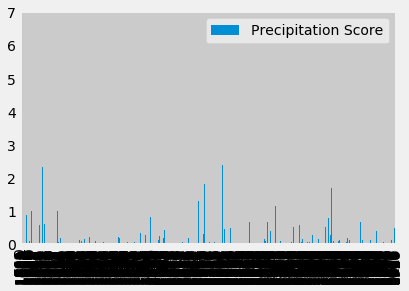

In [98]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='bar')
plt.title("Precipitation from 2016-2017")
plt.
plt.show()

Future Exploration:

In [ ]:
# `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# query that will calculate the daily normals (averages for tmin, tmax, and tavg
# for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")